### 巧达数据分析
> 针对的是巧达给我们的有简历的那一部分数据

In [1]:
from __future__ import division, print_function, unicode_literals
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from Pic.maxent_font import tick_font

from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import LabelEncoder

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
%matplotlib inline
from scipy.stats import chi2_contingency
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap
import datetime
import re
import jieba
import jieba.analyse
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
xls_file = "/Users/chaoxu/code/local-spark/Data/qiaoda/from_qiaoda.xls"
telco_xls = "/Users/chaoxu/code/local-spark/Data/qiaoda/from_telco.xls"
dict_path = "/Users/chaoxu/code/local-spark/Data/qiaoda/qiaoda_dict"
qiaoda_imei = "/Users/chaoxu/code/local-spark/Data/qiaoda/qiaoda_imei.csv"
qiaoda_imei_dec = "/Users/chaoxu/code/local-spark/Data/qiaoda/qiaoda_imei_dec.csv"

In [3]:
df = pd.read_excel(xls_file)

In [4]:
#df = df.loc[df.IMEI.notnull()]

In [5]:
#df['IMEI'] = df['IMEI'].apply(lambda x: x.replace("\t", "")).apply(lambda x: x.replace(" ", ""))

数据预处理：

- 性别全部转化为：男， 女
- 对object类型编码的数据，规划数据变现形式， 比如去掉\t, \s，对NA的数据填入未知
- 对学历数据进行转换
- 对行业就行处理：一般选择就业意向的时候， 第一个行业优先级肯定最高，更能体现当事人的就业意向
- 薪资解析： 需要解析出薪资范围：默认是以xxx元/月为表现形式， 需要额外注意10k以及x万/年的情况。

In [6]:
def transfer_sex(row):
    if row == 'Female' or  row == 'female':
        return u'女'
    elif row == 'male' or row == 'Male':
        return u'男'
    else:
        return row

def format_check(x):
    try:
        return x.strip(" ").lower() if isinstance(x, unicode) or isinstance(x, str) else u'未知'
    except Exception as e:
        return u'未知'
    
education_dict = {
    "bachelor": "本科",
    "master": "硕士",
    "doctor": "博士",
    "mba&emba": "工商管理硕士",
    'mba': "工商管理硕士",
    'emba': "高级工商管理硕士"
}


def convert_edu(x):
    if x in education_dict:
        return education_dict[x]
    else:
        return x


def split_career(text):
    try:
        a = text.split(",")
        a += (3 - len(a)) * [u'未知']
        return a
    except:
        return [u"未知", u"未知", u"未知"]


rp = re.compile(ur'([0-9]+[k,w,K,W]?[\u4e00-\u9fff]?)')


def extract_pay(x):
    return rp.findall(x)[:2]


def get_pay_range(x):
    x_len = len(x)
    pay = "-".join(x)
    if x_len > 0:
        if u'元' in pay:
            low_pay = int(x[0].replace(u'元', u""))
        elif u'万' in pay:
            low_pay = int(x[0].replace(u'万', u"")) * 10000 / 12
        elif u'k' in pay:
            low_pay = int(x[0].replace(u'k', u"")) * 1000
        elif u'w' in pay:
            low_pay = int(x[0].replace(u'w', u"")) * 10000 / 12
        else:
            low_pay = int(x[0])
    else:
        low_pay = None

    if x_len > 1:
        if u'元' in pay:
            high_pay = int(x[1].replace(u'元', u""))
        elif u'万' in pay:
            high_pay = int(x[1].replace(u'万', u"")) * 10000 / 12
        elif u'k' in pay:
            high_pay = int(x[1].replace(u'k', u"")) * 1000
        elif u'w' in pay:
            high_pay = int(x[1].replace(u'w', u"")) * 10000 / 12
        else:
            high_pay = int(x[1])
    else:
        high_pay = None
    return (low_pay, high_pay)


In [7]:
def prepare_qiaoda_feture(df):
    # IMEI可能为空， 以及去掉\t和空格
    df = df.loc[df.IMEI.notnull()]
    df['IMEI'] = df['IMEI'].apply(lambda x: x.replace("\t", "")).apply(lambda x: x.replace(" ", ""))
    df[u'性别'] = df[u'性别'].apply(lambda x : transfer_sex(x))
    feature_cols = df.columns.difference(['IMEI'])
    print("feature columns of qiaoda is {0}".format(feature_cols))
    feature_obj_cols = df.select_dtypes(include=[np.object_]).columns.difference(['IMEI'])
    print("object feature columns is {0}".format(feature_obj_cols))
    # 错误编码数据填入 u'未知', 比如最高学位里面存在时间类型数据
    df[feature_obj_cols] = df[feature_obj_cols].applymap(format_check)
    # 最高学历转化
    # df[u'最高学历'] = df[u'最高学历'].apply(lambda x: convert_edu(x)).apply(lambda x: jieba.analyse.extract_tags(x))
    df[u'最高学历'] = df[u'最高学历'].apply(lambda x: convert_edu(x))
    # 所在地topic获取
    # df[u'所在地'] = df[u'所在地'].apply(lambda x: jieba.analyse.extract_tags(x))
    # 行业划分
    df[u'行业1'], df[u'行业2'], df[u'行业3'] = zip(*df[u'行业'].apply(lambda x: split_career(x)))
    # 薪资处理
    df[u'薪资'] = df[u'薪资'].apply(lambda x: extract_pay(x))
    df[u'薪资下限'], df[u'薪资上限'] = zip(*df[u'薪资'].apply(lambda x: get_pay_range(x)))
    df[[u'薪资下限', u'薪资上限']] = df[[u'薪资下限', u'薪资上限']].apply(np.sort, axis=1)
    df[u'薪资下限'] = df[u'薪资下限'].fillna(df[u'薪资下限'].mean())
    df[u'薪资上限'] = df[u'薪资上限'].fillna(df[u'薪资上限'].mean())
    df = df.drop([u'薪资', u'行业'], axis=1)
    return df

In [8]:
df = prepare_qiaoda_feture(df)

feature columns of qiaoda is Index([u'年龄', u'性别', u'所在地', u'最高学历', u'职位', u'薪资', u'行业'], dtype='object')
object feature columns is Index([u'性别', u'所在地', u'最高学历', u'职位', u'薪资', u'行业'], dtype='object')


In [9]:
df

,IMEI,性别,年龄,最高学历,所在地,职位,行业1,行业2,行业3,薪资下限,薪资上限
0,860268036157172,男,25.0,大专,苏州,区域销售专员/助理,耐用消费品（服饰/纺织/皮革/家具/家电）,未知,未知,6001.000000,8000.000000
1,861064031190576,男,25.0,本科,丽江,通风施工员,房地产/建筑/建材/工程,未知,未知,4001.000000,6000.000000
2,861073031189330,男,21.0,高中,成都 双流区,销售代表,保险,未知,未知,4001.000000,6000.000000
3,861079032014492,男,25.0,大专,河北 唐山,外销专员,贸易/进出口,未知,未知,4001.000000,6000.000000
4,861488037320525,男,38.0,未知,湖北 武汉,未知,未知,未知,未知,4600.752941,6784.545594
5,861504038323175,女,28.0,本科,浙江 杭州,实习生,贸易/进出口,未知,未知,4600.752941,1000.000000
6,862086037818545,男,32.0,本科,哈尔滨 南岗区,销售主管,医药/生物工程,未知,未知,6001.000000,8000.000000
7,862110039764901,男,33.0,中专,天津,普工/操作工,机械/设备/重工,电子技术/半导体/集成电路,仪器仪表/工业自动化,4500.000000,5999.000000
8,862471030134118,男,29.0,高中,未知,未知,未知,未知,未知,4600.752941,6784.545594
9,862503032157018,未知,117.0,未知,萍乡,未知,未知,未知,未知,4600.752941,6784.545594


In [10]:
old_bin_values = np.arange(start=df[u'年龄'].min(), stop=df[u'年龄'].max(), step=5)

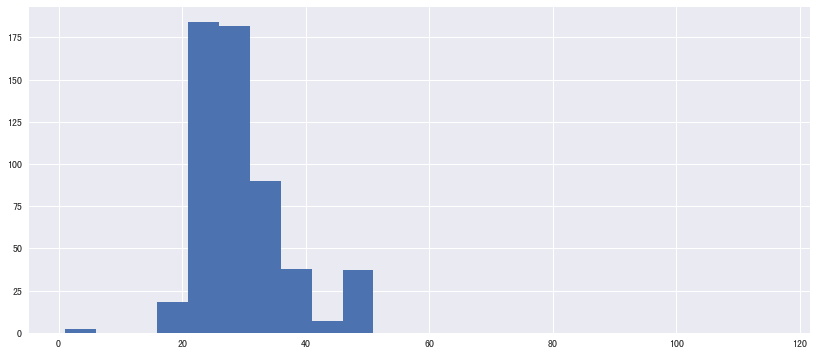

In [11]:
df[u'年龄'].hist(bins=old_bin_values, figsize=[14,6])

In [12]:
# pd.get_dummies(df[u'性别'])

读入maxent给出去的IMEI数据：

- 读入数据
- 处理IMEI列编码, 前五位移到后面
- merge到巧达数据

In [13]:
df_m = pd.read_csv(qiaoda_imei, names=['telco','fraud_type','IMEI'])
df_m = df_m.loc[df_m['IMEI'].notnull()]
df_m['IMEI'] = df_m['IMEI'].apply(lambda x: x[5:] + x[0:5])
df_m.to_csv(qiaoda_imei_dec, index=False)

In [14]:
def create_label(x):
    if x['fraud_type'] == 'qiancheng':
        return 1
    else:
        return 0

In [15]:
df_m['label'] = df_m.apply(create_label, axis=1)

In [16]:
df_m['IMEI'] = df_m['IMEI'].astype(str)
df['IMEI'] = df['IMEI'].astype(str)

In [17]:
df_mq = df.merge(df_m, how='left', on='IMEI')

In [18]:
df_mq.label.value_counts()

0.0    623
1.0     31
Name: label, dtype: int64

In [19]:
def convert_telco(x):
    if isinstance(x, str) or isinstance(x, unicode):
        x = unicode(x.lower(), 'utf-8')
        if u'cmcc' in x:
            return u'中国电信'
        elif u'mobile' in x:
            return u'中国移动'
        elif u'unicom' in x:
            return u'中国联通'
        else:
            return x
    else:
        return u"未知"

In [20]:
# df_mq[df_mq['telco'].apply(lambda x: isinstance(x, str))]

In [21]:
df_mq['telco'] = df_mq['telco'].apply(lambda x: convert_telco(x))

In [22]:
df_mq['fraud_type'] = df_mq['fraud_type'].fillna('unknown')

In [23]:
df_mq['label'] = df_mq['label'].fillna(0)

In [71]:
df_mq.label.value_counts()

0.0    633
1.0     31
Name: label, dtype: int64

In [25]:
df_mq.dtypes

IMEI           object
性别             object
年龄            float64
最高学历           object
所在地            object
职位             object
行业1            object
行业2            object
行业3            object
薪资下限          float64
薪资上限          float64
telco          object
fraud_type     object
label         float64
dtype: object

In [26]:
number = LabelEncoder()
feature_obj_cols = df_mq.select_dtypes(include=[np.object_]).columns.difference(['IMEI'])
print(feature_obj_cols)
for col in feature_obj_cols:
    print(col)
    df_mq[col] = df_mq[col].astype(unicode)
    df_mq[col] = number.fit_transform(df_mq[col])

Index([u'fraud_type', u'telco', u'性别', u'所在地', u'最高学历', u'职位', u'行业1', u'行业2',
       u'行业3'],
      dtype='object')
fraud_type
telco
性别
所在地
最高学历
职位
行业1
行业2
行业3


In [27]:
# feature_obj_cols = df_mq.select_dtypes(include=[np.object_]).columns.difference(['IMEI'])
# print(feature_obj_cols)
# for col in feature_obj_cols:
#     df_mq[col] = df_mq[col].astype(unicode)
#     value_counts = df_mq[col].value_counts()
#     values = value_counts.index.values
#     for i, v in enumerate(values):
#         df_mq[col][df_mq[col] == v] = i

In [28]:
df_mq

,IMEI,性别,年龄,最高学历,所在地,职位,行业1,行业2,行业3,薪资下限,薪资上限,telco,fraud_type,label
0,860268036157172,2,25.0,8,295,71,75,12,11,6001.000000,8000.000000,4,2,1.0
1,861064031190576,2,25.0,11,24,368,43,12,11,4001.000000,6000.000000,0,2,1.0
2,861073031189330,2,21.0,13,159,390,15,12,11,4001.000000,6000.000000,0,1,0.0
3,861079032014492,2,25.0,8,210,110,83,12,11,4001.000000,6000.000000,1,1,0.0
4,861488037320525,2,38.0,10,254,225,55,12,11,4600.752941,6784.545594,0,2,1.0
5,861504038323175,0,28.0,11,228,118,83,12,11,4600.752941,1000.000000,1,2,1.0
6,862086037818545,2,32.0,11,83,388,24,12,11,6001.000000,8000.000000,0,1,0.0
7,862110039764901,2,33.0,2,105,217,57,15,4,4500.000000,5999.000000,1,2,1.0
8,862471030134118,2,29.0,13,180,225,55,12,11,4600.752941,6784.545594,1,2,1.0
9,862503032157018,1,117.0,10,302,225,55,12,11,4600.752941,6784.545594,0,1,0.0


In [29]:
df_mq[u'性别'].value_counts()

2    479
0    132
1     53
Name: 性别, dtype: int64

In [30]:
X_cols = df_mq.columns.difference(['IMEI','label'])

In [31]:
# X = df_mq[X_cols]
# y = df_mq.ix[:, df_mq.columns == 'label']
# v_features = X_cols
# pic_nums = v_features.shape[0]
# import matplotlib.gridspec as gridspec
# plt.figure(figsize=(12,28*4))
# gs = gridspec.GridSpec(pic_nums, 1)
# for i, cn in enumerate(df_mq[v_features]):
#     print("cn",cn)
#     df_mq[cn] = df_mq[cn].astype(float)
#     ax = plt.subplot(gs[i])
# #     cn_1_bin = np.arange(df_mq[cn][df_mq.label == 1].min(), df_mq[cn][df_mq.label == 1].max()+1)
# #     cn_0_bin = np.arange(df_mq[cn][df_mq.label == 0].min(), df_mq[cn][df_mq.label == 0].max()+1)
#     sns.distplot(df_mq[cn][df_mq.label == 1], bins=10)
#     sns.distplot(df_mq[cn][df_mq.label == 0], bins=10)
#     ax.set_xlabel('')
#     ax.set_title('histogram of feature: ' + str(cn))
# plt.show()

In [32]:
df_mq[df_mq.columns.difference(['IMEI'])]= df_mq[df_mq.columns.difference(['IMEI'])].astype(float)

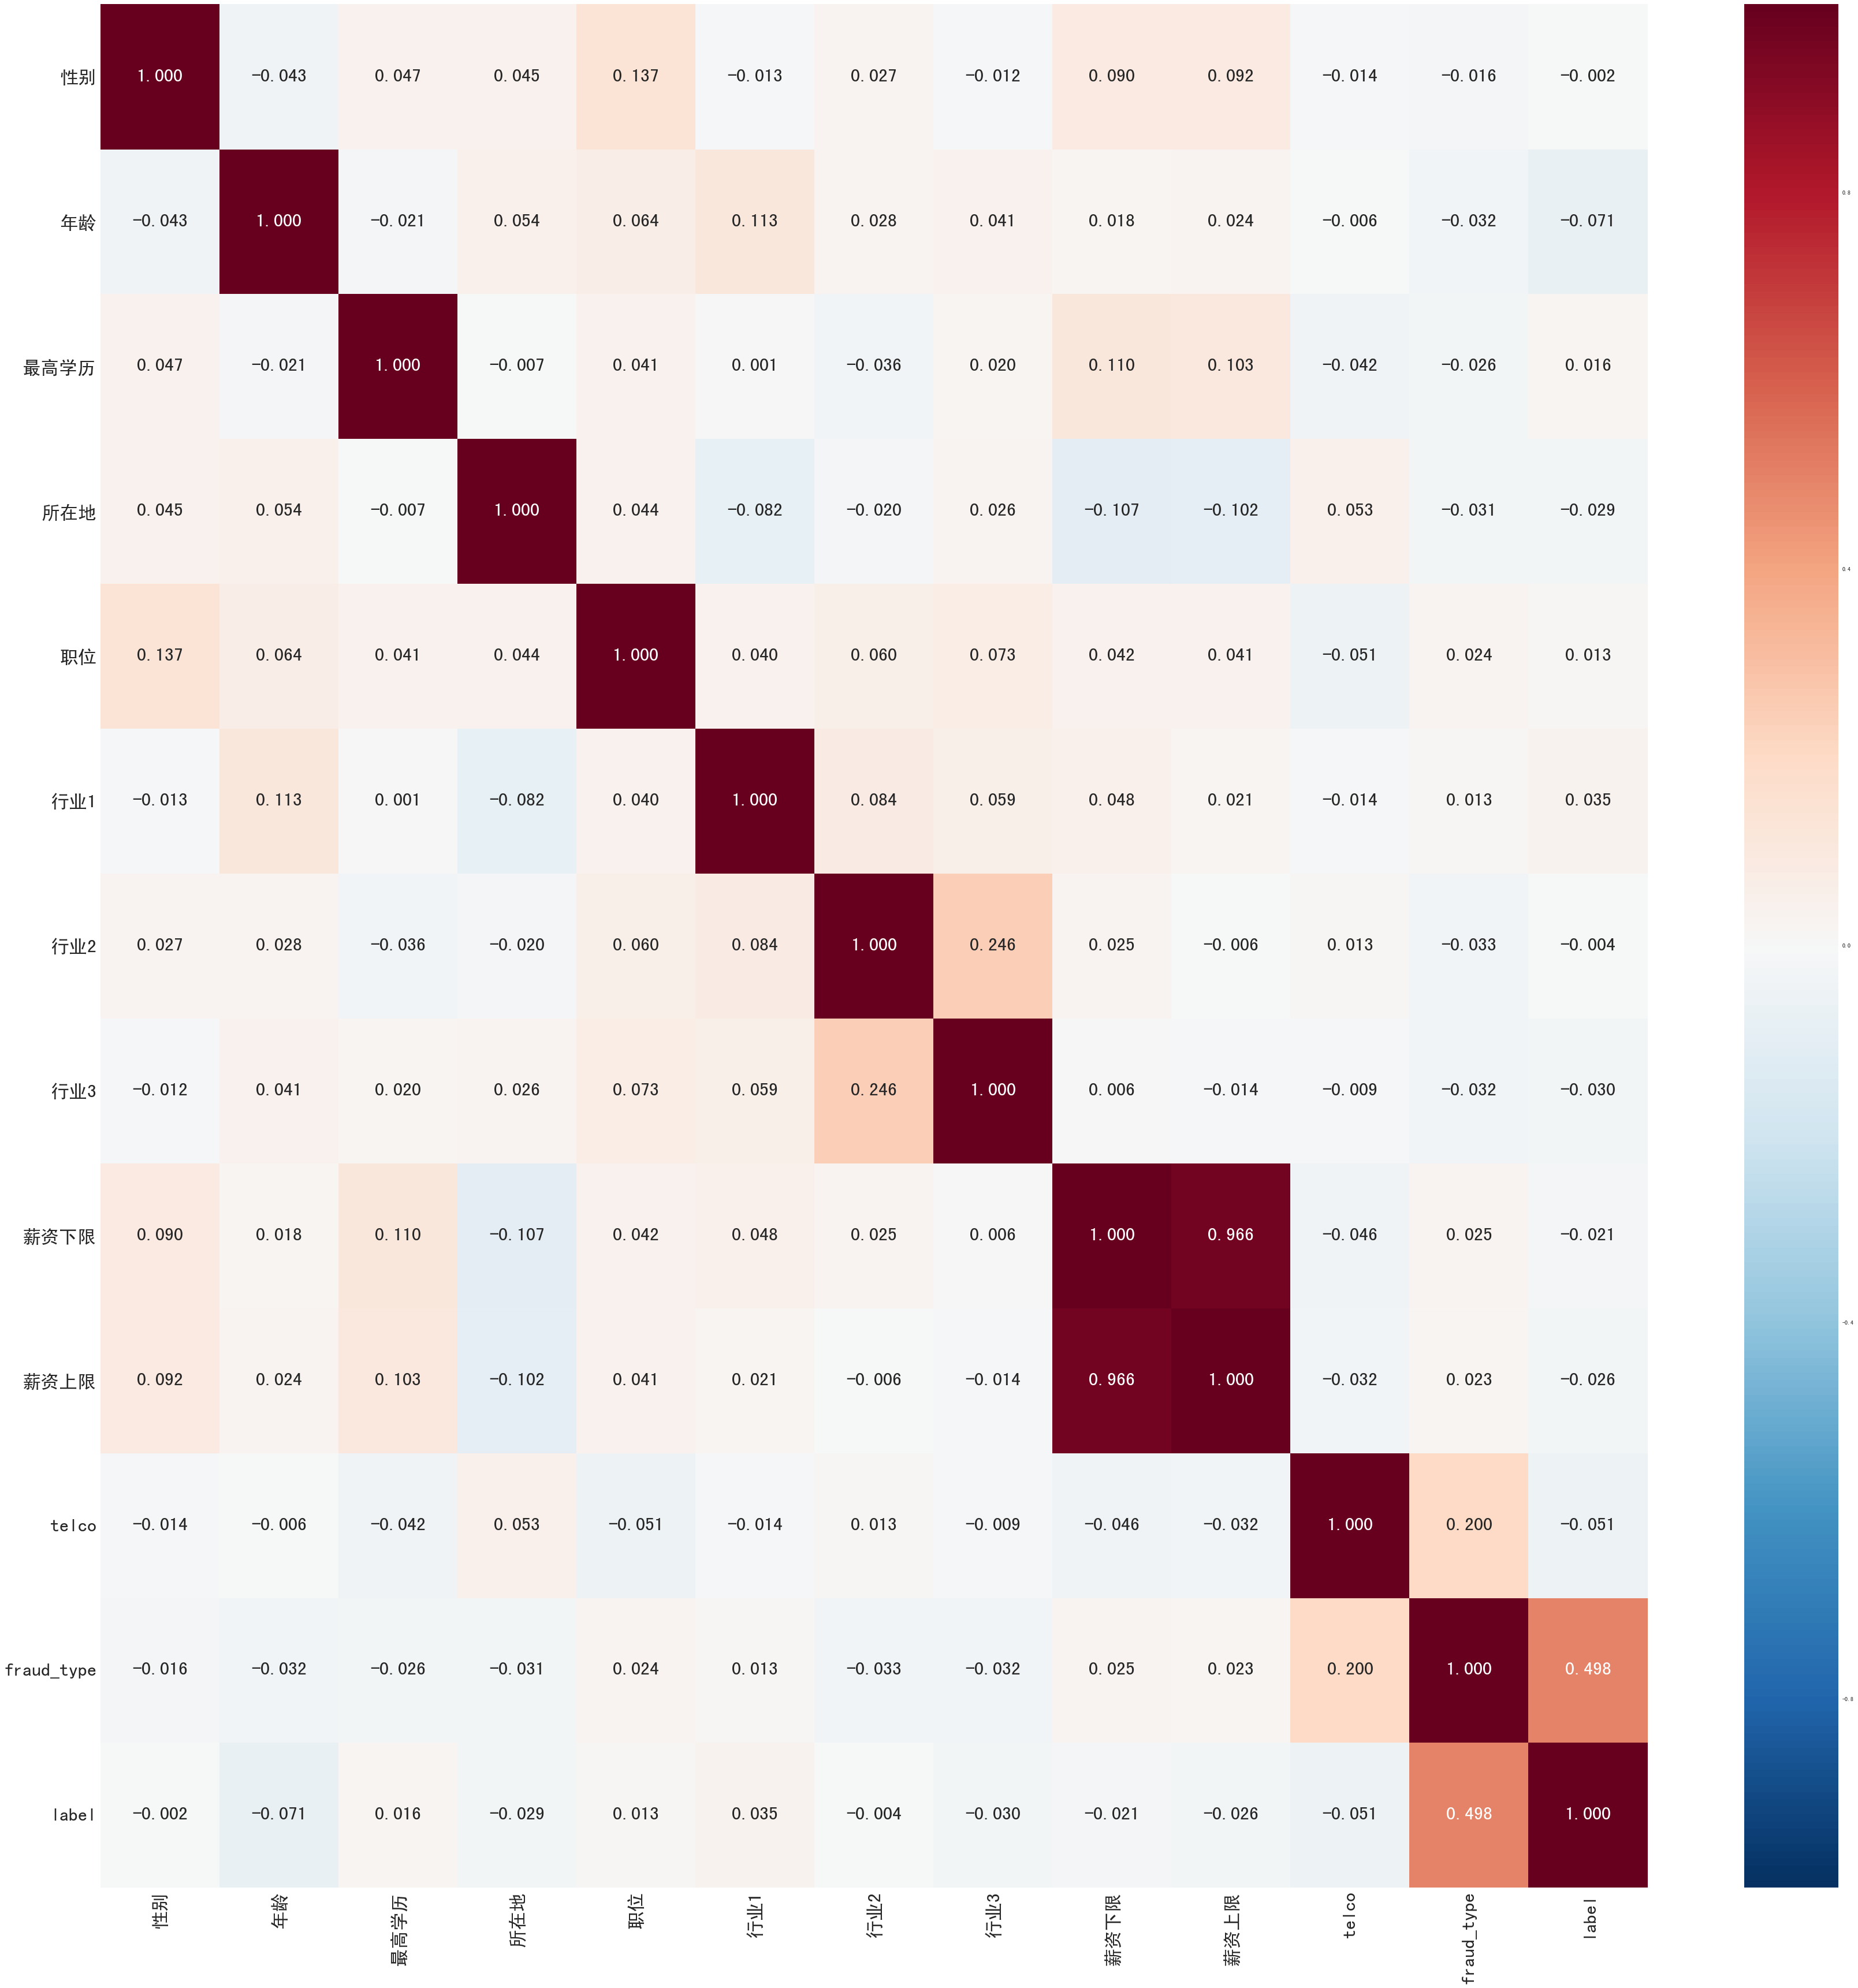

In [38]:
fig,ax= plt.subplots(figsize=(60,60))
sns.heatmap(df_mq.corr(),ax=ax,annot=True,fmt='.3f',annot_kws={"size": 32})
tick_font(ax=ax,font_size=32,rotation_y=0)
plt.show()

分类变量应该统计卡方分布值, 根据卡方独立性假设：

H0： 分类特征与label独立

H1： 分类特征与label相关

In [39]:
chi_cols = df_mq.columns.difference(['IMEI',u'年龄', u'薪资下限', u'薪资上限','label'])

In [40]:
chi_cols

Index([u'fraud_type', u'telco', u'性别', u'所在地', u'最高学历', u'职位', u'行业1', u'行业2',
       u'行业3'],
      dtype='object')

In [42]:
chi2_p = []
for col in chi_cols:
    print(col)
    cross_table = pd.crosstab(df_mq.label, df_mq[col])
    print("chi2 state result:")
    p = chi2_contingency(cross_table)[1]
    print(p)
    chi2_p.append(p)
    print("end----")

fraud_type
chi2 state result:
1.34248269458e-143
end----
telco
chi2 state result:
0.771110984797
end----
性别
chi2 state result:
0.58862148523
end----
所在地
chi2 state result:
0.543779192756
end----
最高学历
chi2 state result:
0.792847561096
end----
职位
chi2 state result:
0.069133373573
end----
行业1
chi2 state result:
0.921217273694
end----
行业2
chi2 state result:
0.0449623854821
end----
行业3
chi2 state result:
0.130424706415
end----


In [53]:
def pic_chi2(chi2_p, chi2_cols):
    fig,ax= plt.subplots(figsize=(10,6))
    chi2_df = pd.DataFrame(chi2_p, index=chi_cols, columns=['chi2_p'])
    chi2_log = chi2_df.plot.bar(ax=ax)
    log_bin_middles = np.array(map(lambda patch:patch._x + patch._width / 2.0 , chi2_log.containers[0]))
    ax.plot(log_bin_middles,[0.05] * len(chi2_p), c='r')
    ax.plot(log_bin_middles,[0.1] * len(chi2_p), c='g')
    plt.show()

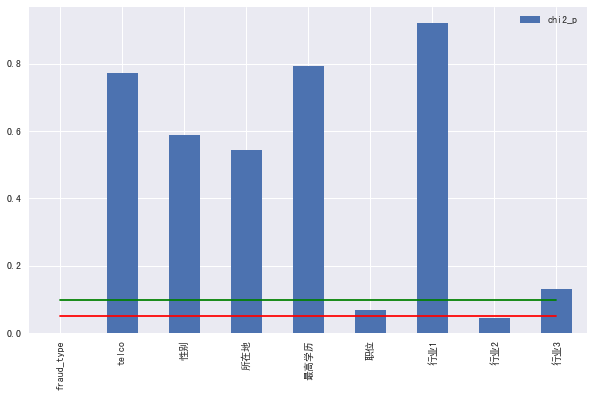

In [54]:
pic_chi2(chi2_p, chi2_cols=chi_cols)

In [66]:
pd.crosstab(df_mq.label, df_mq[u'职位'])[225.0].ix[1.0]

6

In [67]:
pd.crosstab(df_mq.label, df_mq[u'职位']).ix[1.0].max()

6

In [61]:
pd.concat([df_mq[u'职位'],df[u'职位']],axis=1)

,职位,职位
0,71.0,区域销售专员/助理
1,368.0,通风施工员
2,390.0,销售代表
3,110.0,外销专员
4,225.0,未知
5,118.0,实习生
6,388.0,销售主管
7,217.0,普工/操作工
8,225.0,未知
9,225.0,未知


In [65]:
df[u'职位'].value_counts()

未知                                   99
销售代表                                 15
其他                                   14
销售经理                                 14
销售主管                                  9
施工员                                   8
实习生                                   7
仓库管理员                                 6
电话销售                                  6
司机                                    5
机动车司机/驾驶                              5
销售                                    5
业务员                                   5
客户经理                                  5
技工                                    4
行政专员/助理                               4
质量检验员/测试员                             4
主管                                    3
普工/操作工                                3
总经理                                   3
会计                                    3
区域经理                                  3
普工/学徒工                                3
总经理助理                                 3
员工                                    3


In [ ]:
df